# 1.Import Files

In [1]:
import pandas as pd
# set screen
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
 
import matplotlib.pyplot as plt
from pandas import read_excel
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from numpy import concatenate
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
import os
import pandas as pd

Using TensorFlow backend.


# 2.Load and Clean Data

In [2]:
# Convert the string to the float
def str_to_float(s):
    s=s[:-1]
    s_float=float(s)
    return s_float
path=""
excelFile = os.path.join(path,'S&P500.xlsx')

stock_data = pd.read_excel(excelFile,parse_dates=['Date'],index_col='Date')
# Read excel file, transfer the 'date' column to Datetime format and set it to the index
stock_data.columns=['open','high','low','close','adj_close','volume']
stock_data.index.name='date' # set the date column to the index column
# Sort the data according to the datetime
stock_data=stock_data.sort_values(by='date')
# Add a column named 'earn_rate'
stock_data['earn_rate'] = stock_data['close'].pct_change()
# Fill the missing value
stock_data['earn_rate'].fillna(method='bfill',inplace=True)
print(stock_data.head())

                   open         high          low        close    adj_close      volume  earn_rate
date                                                                                              
2012-01-03  1258.859985  1284.619995  1258.859985  1277.060059  1277.060059  3943710000   0.000188
2012-01-04  1277.030029  1278.729980  1268.099976  1277.300049  1277.300049  3592580000   0.000188
2012-01-05  1277.300049  1283.050049  1265.260010  1281.060059  1281.060059  4315950000   0.002944
2012-01-06  1280.930054  1281.839966  1273.339966  1277.810059  1277.810059  3656830000  -0.002537
2012-01-09  1277.829956  1281.989990  1274.550049  1280.699951  1280.699951  3371600000   0.002262


### Nomalization

In [3]:
# Gain the values of the stock_data, format:array
values=stock_data.values
# Ensure all the data type is float32
values=values.astype('float32')
# Normalization of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)

[[0.0000000e+00 6.8808794e-03 0.0000000e+00 ... 0.0000000e+00
  5.1657510e-01 4.9982917e-01]
 [2.0849228e-02 0.0000000e+00 1.0654926e-02 ... 2.8109550e-04
  4.4926462e-01 4.9982917e-01]
 [2.1159053e-02 5.0468445e-03 7.3801279e-03 ... 4.6851635e-03
  5.8793235e-01 5.5449271e-01]
 ...
 [9.3018925e-01 9.4044328e-01 9.0539658e-01 ... 9.4204462e-01
  6.1528933e-01 6.1672288e-01]
 [9.3952930e-01 9.3334031e-01 9.0613472e-01 ... 9.0144765e-01
  4.5237008e-01 1.6578013e-01]
 [9.0748131e-01 9.2939186e-01 9.1198099e-01 ... 9.0687072e-01
  4.2132095e-01 5.4097426e-01]]


### Supervised Function

In [4]:
# Transfer the problem into supervised problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
# delete the columns exclude 'earn_rate'
reframed.drop(reframed.columns[[7,8,9,10,11,12]], axis=1, inplace=True)
print(reframed.head())

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)
1     0.000000   0.006881   0.000000   0.000000   0.000000   0.516575   0.499829  0.020849  0.000000  0.010655  0.000281  0.000281  0.449265  0.499829
2     0.020849   0.000000   0.010655   0.000281   0.000281   0.449265   0.499829  0.021159  0.005047  0.007380  0.004685  0.004685  0.587932  0.554493
3     0.021159   0.005047   0.007380   0.004685   0.004685   0.587932   0.554493  0.025324  0.003633  0.016697  0.000879  0.000879  0.461581  0.445779
4     0.025324   0.003633   0.016697   0.000879   0.000879   0.461581   0.445779  0.021767  0.003808  0.018093  0.004263  0.004263  0.406903  0.540962
5     0.021767   0.003808   0.018093   0.004263   0.004263   0.406903   0.540962  0.025141  0.020713  0.025265  0.017593  0.017593  0.569915  0.672358
..         ...        ...        ...        ...        ...        ...        ...       ...    

# 3.Split Data Set

In [6]:
# split the data into train set and test set
split_size = 0.25
values = reframed.values
#train = np.concatenate([values[:len(values)*split_size, :],values[488:,:]])
split_position = int(len(values)*split_size)
train = values[:split_position, :]
test = values[split_position:len(values), :]
# split the input data and label from train set and test set
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(test_X)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

[[0.10843372 0.09731424 0.09742844 ... 0.0970062  0.53616655 0.5921061 ]
 [0.11591518 0.1263566  0.11648989 ... 0.12864268 0.4075168  0.89008224]
 [0.14682734 0.12972116 0.13627768 ... 0.12972033 0.37538078 0.5092604 ]
 ...
 [0.93527234 0.9344504  0.9219786  ... 0.9273099  0.42890254 0.41950035]
 [0.93018925 0.9404433  0.9053966  ... 0.9420446  0.61528933 0.6167229 ]
 [0.9395293  0.9333403  0.9061347  ... 0.90144765 0.45237008 0.16578013]]
(220, 1, 7) (220,)
(663, 1, 7) (663,)


# 4.Build Machine Learning Model

Train on 220 samples, validate on 663 samples
Epoch 1/50
 - 1s - loss: 0.4891 - val_loss: 0.4777
Epoch 2/50
 - 0s - loss: 0.4724 - val_loss: 0.4341
Epoch 3/50
 - 0s - loss: 0.4461 - val_loss: 0.3904
Epoch 4/50
 - 0s - loss: 0.4225 - val_loss: 0.3468
Epoch 5/50
 - 0s - loss: 0.4021 - val_loss: 0.3033
Epoch 6/50
 - 0s - loss: 0.3787 - val_loss: 0.2604
Epoch 7/50
 - 0s - loss: 0.3510 - val_loss: 0.2197
Epoch 8/50
 - 0s - loss: 0.3286 - val_loss: 0.1845
Epoch 9/50
 - 0s - loss: 0.3048 - val_loss: 0.1589
Epoch 10/50
 - 0s - loss: 0.2782 - val_loss: 0.1481
Epoch 11/50
 - 0s - loss: 0.2561 - val_loss: 0.1535
Epoch 12/50
 - 0s - loss: 0.2350 - val_loss: 0.1720
Epoch 13/50
 - 0s - loss: 0.2076 - val_loss: 0.2020
Epoch 14/50
 - 0s - loss: 0.1896 - val_loss: 0.2400
Epoch 15/50
 - 0s - loss: 0.1803 - val_loss: 0.2818
Epoch 16/50
 - 0s - loss: 0.1672 - val_loss: 0.3243
Epoch 17/50
 - 0s - loss: 0.1528 - val_loss: 0.3632
Epoch 18/50
 - 0s - loss: 0.1540 - val_loss: 0.3953
Epoch 19/50
 - 0s - loss: 0

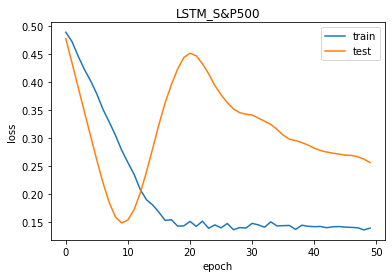

In [7]:
# Build LSTM model 
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))

model.add(Dense(1,activation='relu'))
model.compile(loss='mae', optimizer='adam')


# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2,shuffle=False)
model.save('lstm_model.h5')
# paint the loss picture
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM_S&P500', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

# 5.BackTest

In [8]:
# Predict the earn_rate
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_y_test = concatenate((test_X[:, :6],y_predict), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]
 
X = test_X[-1]
print(X)
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = concatenate((test_X[:, :6],test_y), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]
print('Prediction value after nomalization:',inv_y_predict)
print('True value after nomalization:',inv_y)

[0.9395293  0.9333403  0.9061347  0.90144765 0.90144765 0.45237008
 0.16578013]
Prediction value after nomalization: [ 4.01144469e-04  2.74958997e-03 -1.15905865e-03 -1.78116502e-03
 -1.50157150e-03 -1.59813988e-03 -1.62068708e-03  1.13076298e-03
  7.21424178e-04  1.13611773e-03 -1.65803637e-03 -8.83882341e-04
  1.76597072e-03  1.91961706e-04  5.91588687e-05 -6.44942105e-04
  2.11471575e-03  1.13359059e-03 -1.14724634e-03 -1.21864711e-03
  2.75317486e-03  4.87691723e-03  1.44125283e-04  2.41293665e-03
  2.28323648e-03 -4.31846827e-03 -2.93145981e-03 -1.33171387e-03
 -4.32292279e-03  3.05771804e-03  7.74389692e-03  1.79220946e-03
  2.49725394e-03  6.14491990e-04  1.03195303e-03  2.43262784e-03
  4.48138919e-03  1.56180013e-03  6.85626874e-04  1.37581222e-03
  1.71510084e-03  3.67000746e-03  3.52911395e-03  3.47534125e-03
  2.98027578e-03  3.02955322e-03  3.81680555e-03  2.18892470e-03
  4.84978314e-03  2.56626750e-03  3.23820696e-03  5.71657205e-03
  3.09582305e-04  5.30838734e-03  3.42

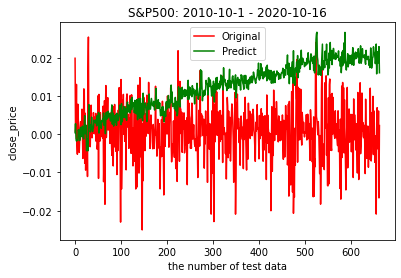

In [9]:
plt.plot(inv_y,color='red',label='Original')
plt.plot(inv_y_predict,color='green',label='Predict')
plt.xlabel('the number of test data')
plt.ylabel('close_price')
plt.title('S&P500: 2010-10-1 - 2020-10-16')
plt.legend()
plt.show()

In [10]:
# Calculate MSE 
mse=mean_squared_error(inv_y,inv_y_predict)
# Calculate RMSE 
rmse = sqrt(mean_squared_error(inv_y, inv_y_predict))
# Calculate MAE 
mae=mean_absolute_error(inv_y,inv_y_predict)
# Calculate R square
r_square=r2_score(inv_y,inv_y_predict)
print('mse: %.6f' % mse)
print('rmse: %.6f' % rmse)
print('mae: %.6f' % mae)
print('R_square: %.6f' % r_square)

mse: 0.000238
rmse: 0.015433
mae: 0.012912
R_square: -3.575964


# 6.Predict the earn_rate of Next Day

In [11]:
X = X.reshape((1,1,7))
from keras.models import load_model
# Load model from single model file
model = load_model('lstm_model.h5')
# Predict the earn_rate
y_predict2 = model.predict(X)
X = X.reshape((1,7))
# Invert scaling for forecast
inv_y_test2 = concatenate((X[:, :6],y_predict2), axis=1)
inv_y_test2 = scaler.inverse_transform(inv_y_test2)
inv_y_predict2=inv_y_test2[:,-1]
print('S&P500 index quote rate of next day',inv_y_predict2)

S&P500 index quote rate of next day [0.01607243]
